# 1. Ablation Study 실습(1)
- dataset: CIFAR-10 dataset
- method: 일반 네트워크 vs. ResNet
- objective: ResNet, Residual connection의 유효성 확인


In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
!pip install torchinfo
from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


## 1.1 dataset

CIRAR-10

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s] 


In [3]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10


In [4]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


Normalization

In [6]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

In [8]:
num_classes = len(trainset.classes)
print(num_classes)

class_names = trainset.classes
print(class_names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [10]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

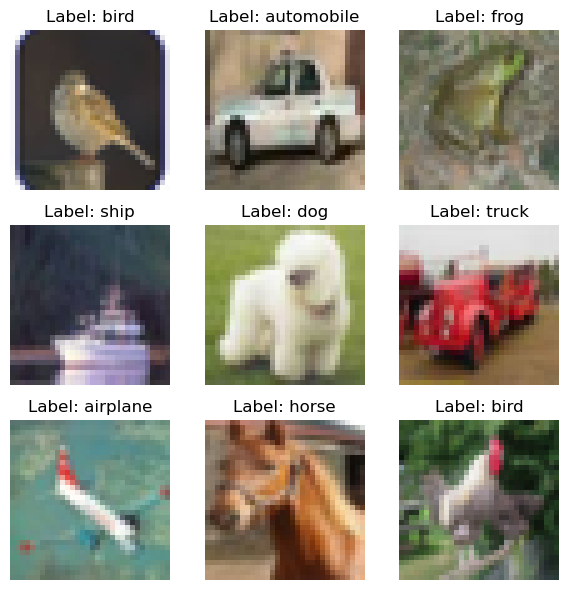

In [11]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

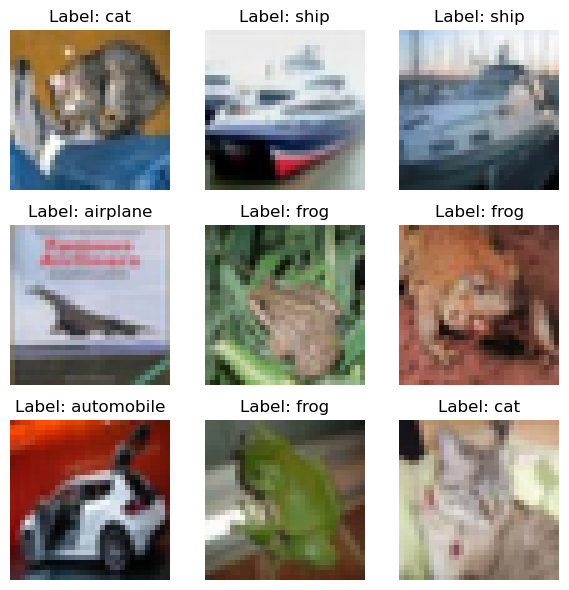

In [12]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

## 1.2 블록 구성하기

### VGG 기본 블록 만들기  

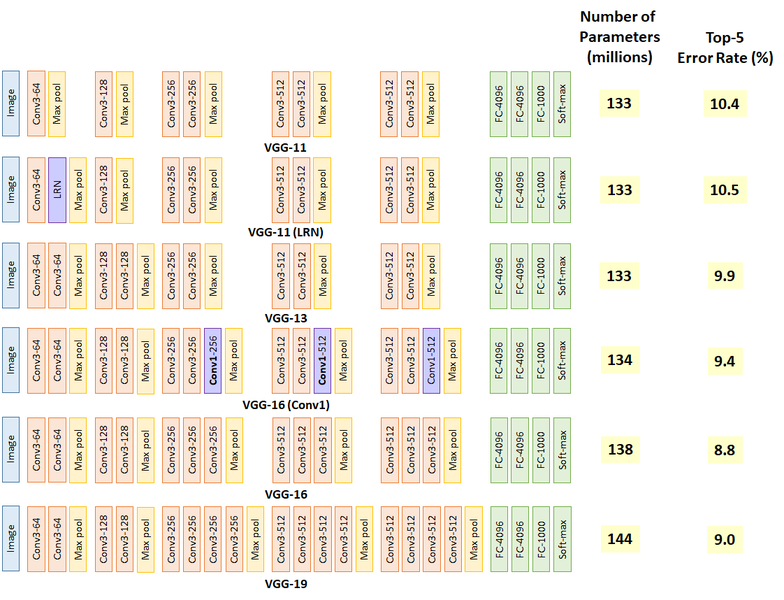  
- 기본구조: CNN 레이어 여러 개 + Max pooling 레이어 한 개
  - CNN의 커널 크기는 3*3
  - 블록 내 CNN 채널은 하나로 유지, 다른 블록 간 CNN 채널 수는 다를 수 있음. 레이어 수도 다를 수 있음
    -> (ex.VGG-16에서 블록1: Conv3-64 2개, 블록2: Conv3-128 2개, 블록3: Conv3-256 3개)

In [79]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channel,
                kernel_size=3,
                stride=1,
                padding=1,
            )
        )
        layers.append(nn.ReLU(inplace=True))
        in_channels = channel

    # Max Pooling 레이어
    layers.append(
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [41]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG 블록 생성
        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32)) # 위에서 입력 Image shape: torch.Size([3, 32, 32])
        
    def forward(self, x):
        return self.vgg_block(x)

In [19]:
# 블록 1개짜리 model 생성
model = VGGNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32) # 위에서 입력 Image shape: torch.Size([3, 32, 32])
output = model(dummy_input)
print(output.shape)

VGGNet(
  (vgg_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 64, 16, 16])


## 1.3 VGG Complete Model


### VGG-16

In [22]:
# VGG 모델 자체를 생성하는 클래스입니다.
class VGG(nn.Module):
    def __init__(self, num_cnn_list=[2, 2, 3, 3, 3], channel_list=[64, 128, 256, 512, 512], num_classes=10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 합니다."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list): ## num_cnn_list, channel_list를 입력하면 다른 VGG-* 생성됨
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels  # 다음 블록의 입력 채널을 설정

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [23]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = VGG()
print(vgg_16)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

### VGG-19

In [24]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
summary(vgg_19)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 590,080
│    │    └─ReLU: 3-16                  

### VGG-13

In [25]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )

In [26]:
vgg_13 = build_vgg13()
summary(vgg_13)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─MaxPool2d: 3-15              --
│    └─Sequential: 2-4                   --
│

## 1.4 VGG-16 vs VGG-19

In [27]:
BATCH_SIZE = 256
EPOCH = 15

In [28]:
# CIFAR-10 데이터셋에 대해 Normalize와 Tensor 변환을 적용하는 코드
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-16 표준 정규화
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
# VGG-16

import time

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_16 = torchvision.models.vgg16(pretrained=True)
vgg_16.to(device)

for param in vgg_16.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_16_train_losses = []
vgg_16_val_accuracy = []

for epoch in range(EPOCH):
    vgg_16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")
            
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    vgg_16_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_16.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_16_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 158MB/s] 


[1,   100] loss: 3.914
Epoch 1: Train Accuracy: 40.31%
Epoch 1: Validation Accuracy: 65.12%
[2,   100] loss: 1.923
Epoch 2: Train Accuracy: 70.43%
Epoch 2: Validation Accuracy: 74.82%
[3,   100] loss: 1.674
Epoch 3: Train Accuracy: 78.42%
Epoch 3: Validation Accuracy: 78.28%
[4,   100] loss: 1.542
Epoch 4: Train Accuracy: 82.07%
Epoch 4: Validation Accuracy: 80.80%
[5,   100] loss: 1.462
Epoch 5: Train Accuracy: 84.56%
Epoch 5: Validation Accuracy: 82.59%
[6,   100] loss: 1.392
Epoch 6: Train Accuracy: 86.62%
Epoch 6: Validation Accuracy: 82.69%
[7,   100] loss: 1.352
Epoch 7: Train Accuracy: 88.28%
Epoch 7: Validation Accuracy: 83.25%
[8,   100] loss: 1.298
Epoch 8: Train Accuracy: 89.96%
Epoch 8: Validation Accuracy: 84.07%
[9,   100] loss: 1.264
Epoch 9: Train Accuracy: 91.34%
Epoch 9: Validation Accuracy: 84.23%
[10,   100] loss: 1.227
Epoch 10: Train Accuracy: 92.44%
Epoch 10: Validation Accuracy: 84.78%
[11,   100] loss: 1.188
Epoch 11: Train Accuracy: 93.73%
Epoch 11: Validation

In [30]:
# VGG-19

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_19 = torchvision.models.vgg19(pretrained=True)
vgg_19.to(device)

for param in vgg_19.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_19_train_losses = []
vgg_19_val_accuracy = []

for epoch in range(EPOCH):
    vgg_19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")

    train_loss = running_loss / len(trainloader)
    vgg_19_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_19.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_19(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_19_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:22<00:00, 25.5MB/s] 


[1,   100] loss: 3.741
Epoch 1: Train Accuracy: 42.13%
Epoch 1: Validation Accuracy: 69.91%
[2,   100] loss: 1.808
Epoch 2: Train Accuracy: 73.71%
Epoch 2: Validation Accuracy: 78.01%
[3,   100] loss: 1.602
Epoch 3: Train Accuracy: 80.79%
Epoch 3: Validation Accuracy: 81.71%
[4,   100] loss: 1.487
Epoch 4: Train Accuracy: 84.03%
Epoch 4: Validation Accuracy: 82.74%
[5,   100] loss: 1.422
Epoch 5: Train Accuracy: 86.21%
Epoch 5: Validation Accuracy: 83.96%
[6,   100] loss: 1.357
Epoch 6: Train Accuracy: 87.91%
Epoch 6: Validation Accuracy: 84.49%
[7,   100] loss: 1.321
Epoch 7: Train Accuracy: 89.29%
Epoch 7: Validation Accuracy: 85.51%
[8,   100] loss: 1.272
Epoch 8: Train Accuracy: 90.79%
Epoch 8: Validation Accuracy: 85.36%
[9,   100] loss: 1.234
Epoch 9: Train Accuracy: 92.03%
Epoch 9: Validation Accuracy: 85.78%
[10,   100] loss: 1.205
Epoch 10: Train Accuracy: 93.07%
Epoch 10: Validation Accuracy: 86.40%
[11,   100] loss: 1.172
Epoch 11: Train Accuracy: 94.22%
Epoch 11: Validation

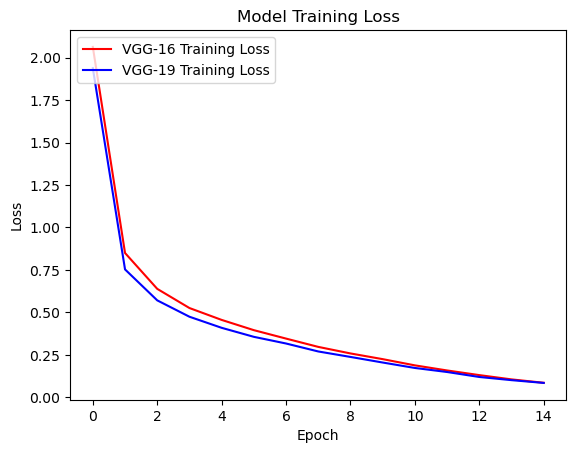

In [31]:
# 그래프 비교

import matplotlib.pyplot as plt

plt.plot(vgg_16_train_losses, 'r', label="VGG-16 Training Loss")
plt.plot(vgg_19_train_losses, 'b', label="VGG-19 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

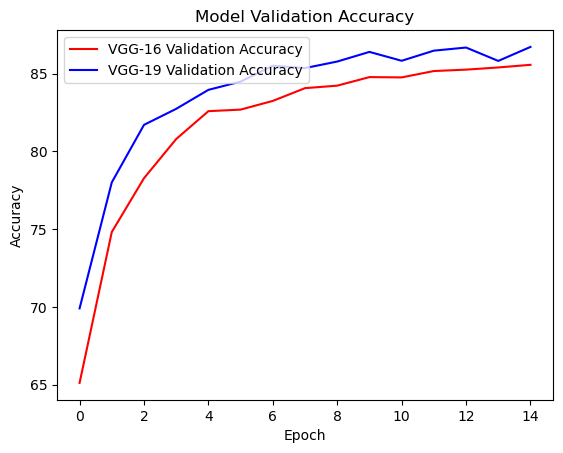

In [32]:
# 검증 정확도(Validation accuracy) 비교

plt.plot(vgg_16_val_accuracy, 'r', label="VGG-16 Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label="VGG-19 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 2. 프로젝트: ResNet Ablation Study

라이브러리 버전 확인하기

In [3]:
import torch
import numpy as np

print(torch.__version__)
print(np.__version__)

2.7.1+cu118
2.2.6


## 2.1 ResNet 기본 블록 구성하기

   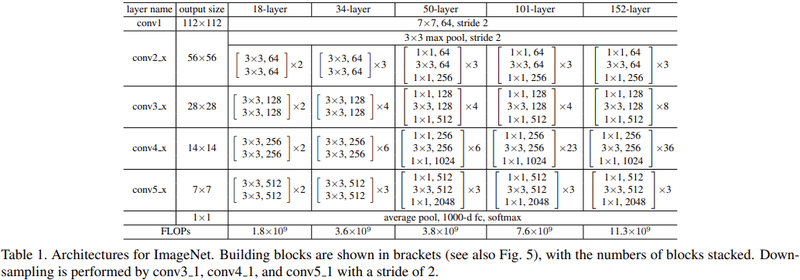  
   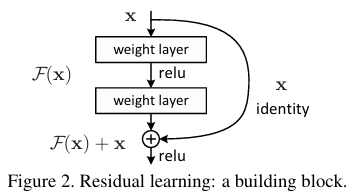  
   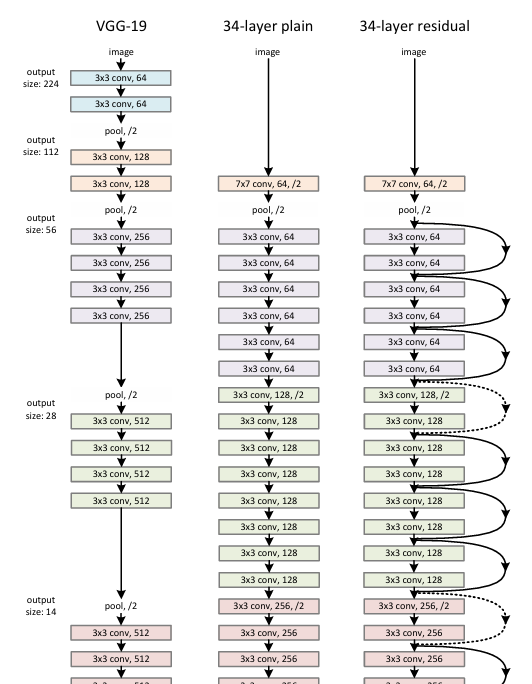  
   

   - ResNet-34와 ResNet-50 비교하기
     - conv1은 7*7, 64, stride 2로 동일함
     - 마지막 layer도 1*1 size의 average pool, 1000-d fe, softmax로 동일함
     - conv2_x, conv3_x, conv4_x, conv5_x 블록을 3, 4, 6, 3개씩 반복해서 쌓은 형태임  
       내부 구조:
       - ResNet-34은 커널 크기 3*3인 Convolution layer로만 구성되어있음
       - ResNet-50은 커널 크기 3*3인 Convolution layer 1개에 1*1 Convolution layer 1개가 앞뒤로 붙어있음
       - 채널은 블록마다 64, 128, 256, 512로 다름

In [4]:
# function for building ResNet Block (기본구조 세팅)
'''
Conv → BN → ReLU
Conv → BN
+ identity
→ ReLU
'''

def build_resnet_block(input_layer, num_cnn=2, channel=64, block_num=1):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channel, kernel_size=3, stride=1, padding=1)) # conv2_x stride=1, conv3_x부터 stride=2
        layers.append(nn.BatchNorm2d(channel)) # 채널 수 맞춰서 BatchNorm 생성

        if cnn_num != num_cnn - 1:
            layers.append(nn.ReLU(inplace=True)) # 마지막 conv 제외하고 나머지 레이어에만 relu 추가
            
        in_channels = channel

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # ResNet 블록 생성
        self.resnet_block = build_resnet_block(torch.zeros(1, 3, 32, 32), num_cnn=2, channel=64) # 위에서 입력 Image shape: torch.Size([3, 32, 32])
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x # 추가. 잔차 connection
        out = self.resnet_block(x)
    
        # 공간 크기 맞추기
        if identity.shape[2:] != out.shape[2:]:
            identity = F.interpolate(identity, size=out.shape[2:], mode="nearest") # identity를 out과 동일한 공간 크기로 맞춤
    
        # 채널 수 맞추기
        if identity.size(1) != out.size(1):
            diff = out.size(1) - identity.size(1) 
            identity = F.pad(identity, (0, 0, 0, 0, 0, diff)) # 차이(diff)만큼 identity에 padding
    
        out = out + identity

        return self.relu(out)

In [6]:
# 테스트 - 블록 1개짜리 model 생성
model = ResNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32)
output = model(dummy_input)
print(output.shape)

ResNet(
  (resnet_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
)
torch.Size([1, 64, 32, 32])


## 2.2 ResNet-34, ResNet-50 Complete Model

In [7]:
# Sequential API? Functional API!

ResNet-34  
```
Input: 3×32×32
↓
conv1: 7×7, 64, stride=2, padding=3 → 16×16
↓
BN → ReLU
↓
maxpool: 3×3, stride=2, padding=1 → 8×8
↓
stage1 (conv2_x): [3×3, 64 → 3×3,64] × 3
stage2 (conv3_x): [3×3, 128 → 3×3, 128] × 4, first stride=2
stage3 (conv4_x): [3×3, 256 → 3×3, 256] × 6, first stride=2
stage4 (conv5_x): [3×3, 512 → 3×3, 512] × 3, first stride=2
↓
AdaptiveAvgPool(1×1)
↓
FC(10)
```

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
!pip install torchinfo


In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=True # bias True/False 설정에 따라 parameter 수가 달라짐. 왜??
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=True
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=True
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out


In [11]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 64

        # stem
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        # stages
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        # 첫 블록 stride 적용
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [12]:
def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

In [13]:
resnet34 = ResNet34(num_classes=37)
summary(resnet34, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Identity: 3-1                [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    └─BasicBlock: 2-2                   [1, 64, 56, 56]           --
│

ResNet-50  
```
Input: 3×32×32
↓
conv1: 7×7, 64, stride=2, padding=3 → 16×16
↓
BN → ReLU
↓
maxpool: 3×3, stride=2, padding=1 → 8×8
↓
stage1 (conv2_x): [1×1,64 → 3×3,64 → 1×1,256] × 3
stage2 (conv3_x): [1×1,64 → 3×3,128 → 1×1,512] × 4, first stride=2
stage3 (conv4_x): [1×1,64 → 3×3,256 → 1×1,1024] × 6, first stride=2
stage4 (conv5_x): [1×1,64 → 3×3,512 → 1×1,2048] × 3, first stride=2
↓
AdaptiveAvgPool(1×1)
↓
FC(10)
```

In [14]:
class Bottleneck(nn.Module):
    expansion = 4  # ResNet-50 핵심

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # 1x1 conv (channel reduction)
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1, stride=stride, bias=True # bias True/False 설정에 따라 parameter 수가 달라짐. 왜??
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 conv
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=True
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1 conv
        self.conv3 = nn.Conv2d(
            out_channels, out_channels * self.expansion,
            kernel_size=1, bias=True
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # shortcut
        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels * self.expansion,
                    kernel_size=1, stride=stride, bias=True
                ),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = F.relu(out)

        return out


In [15]:
def ResNet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

In [16]:
resnet50 = ResNet50(num_classes=37)
summary(resnet50, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Sequential: 3-1              [1, 256, 56, 56]          17,152
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           4,160
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-6                  [1, 256, 56, 56]          1

## 2.3 일반 네트워크(plain network) 만들기  
- ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요.
- 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [17]:
# use_skip 추가함

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, use_skip=True):
        super().__init__()
        self.use_skip = use_skip # use_skip 추가함

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=True # bias True/False 설정에 따라 parameter 수가 달라짐. 왜??
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=True
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        if self.use_skip: # use_skip = True 일때만 활성
            self.shortcut = nn.Identity()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_channels, out_channels,
                        kernel_size=1, stride=stride, bias=True
                    ),
                    nn.BatchNorm2d(out_channels)
                )
        else:
            self.shortcut = None  # skip 안 쓰면 None

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
    
        out = self.conv2(out)
        out = self.bn2(out)
    
        if self.use_skip:
            identity = x if self.shortcut is None else self.shortcut(x)
            out += identity
    
        out = F.relu(out)
        
        return out

In [18]:
# use_skip 추가함

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, use_skip=True): #use_skip=True 추가
        super().__init__()
        self.in_channels = 64
        self.use_skip = use_skip # use_skip추가

        # stem
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        # stages
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        # head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        # 첫 블록 stride 적용
        layers.append(block(self.in_channels, out_channels, stride, use_skip=self.use_skip)) # use_skip추가
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, use_skip=self.use_skip)) # use_skip추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [19]:
def build_plainnet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, use_skip=False)

In [20]:
plain_resnet34 = build_plainnet34(num_classes=37)
summary(plain_resnet34, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─BasicBlock: 2-2                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,9

In [21]:
# use_skip 추가함

class Bottleneck(nn.Module):
    expansion = 4  # ResNet-50 핵심

    def __init__(self, in_channels, out_channels, stride=1, use_skip=True):
        super().__init__()
        self.use_skip = use_skip

        # 1x1 conv (channel reduction)
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 conv (stride 적용)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1 conv (channel expansion)
        self.conv3 = nn.Conv2d(
            out_channels, out_channels * self.expansion,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # shortcut
        self.shortcut = nn.Identity()
        if self.use_skip:
            if stride != 1 or in_channels != out_channels * self.expansion:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_channels, out_channels * self.expansion,
                        kernel_size=1, stride=stride, bias=False
                    ),
                    nn.BatchNorm2d(out_channels * self.expansion)
                )
        else:
            self.shortcut = None  # skip connection 제거

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.use_skip:
            identity = x if self.shortcut is None else self.shortcut(x)
            out += identity

        out = F.relu(out)
        return out


In [22]:
def build_plainnet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, use_skip=False)

In [23]:
plain_resnet50 = build_plainnet50(num_classes=37)
summary(plain_resnet50, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-5                  [1, 256, 56, 56]          16,384
│    │    └─BatchNorm2d: 3-6             [1, 256, 56, 56]          5

## 2.4 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### 데이터 로드

In [ ]:
BATCH_SIZE = 64
EPOCH = 10

# resnet34 resnet50 plain_model34 plain_model50

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기 맞춤
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',    # train set
    download=True,
    transform=transform,
    target_types='category'  # 클래스 라벨
)

testset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='test',        # test set
    download=True,
    transform=transform,
    target_types='category'
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

#### 데이터 탐색

In [32]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 224, 224])
Label: 0
Number of classes: 37


In [33]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 3680 (Shape: torch.Size([]))
Test dataset size: 3669 (Shape: torch.Size([]))


In [34]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

In [35]:
num_classes = len(trainset.classes)
print(num_classes)

37


In [36]:
class_names = trainset.classes
print(class_names)

['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [37]:
def imshow(img):
    img = img / 2 + 0.5
    img = torch.clamp(img, 0, 1)  # 0~1 범위로 클리핑
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [38]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    n_images = min(n_images, len(images))  # 배치 크기보다 크게 요청하면 조정
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


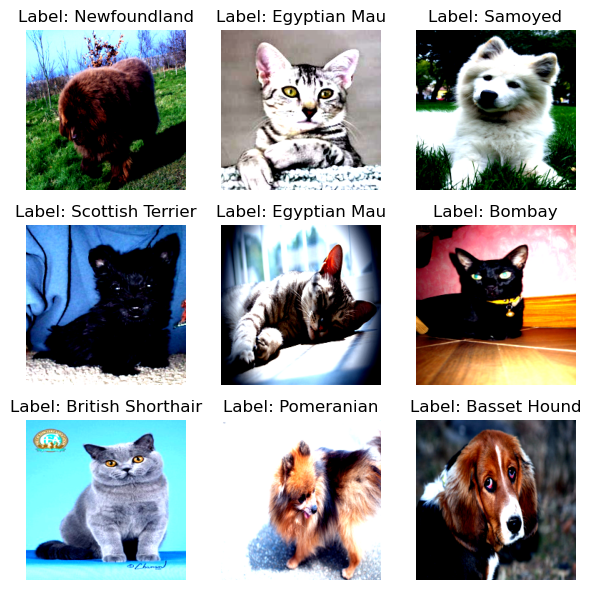

In [39]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

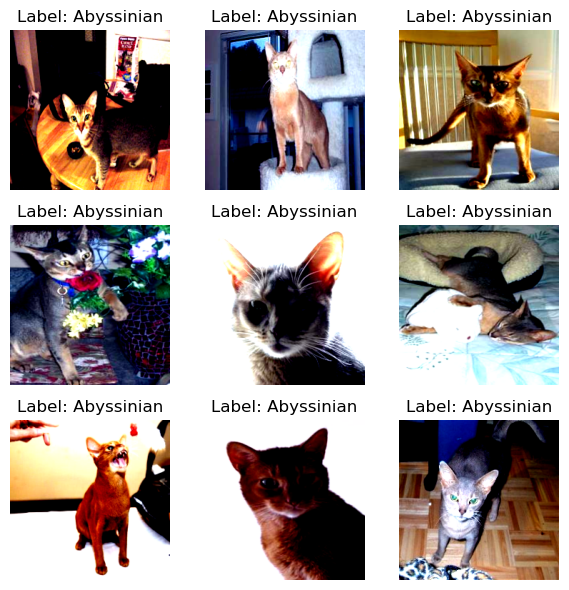

In [40]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

### 모델 준비 (다시 테스트하기)

In [41]:
resnet34 = ResNet34(num_classes=37)
resnet50 = ResNet50(num_classes=37)
plain_resnet34 = build_plainnet34(num_classes=37)
plain_resnet50 = build_plainnet50(num_classes=37)

In [42]:
'''
import time

current_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet34 = ResNet34(num_classes=37)
resnet50 = ResNet50(num_classes=37)
plain_resnet34 = build_plainnet34(num_classes=37)
plain_resnet50 = build_plainnet50(num_classes=37)

# 학습할 모델 딕셔너리
models_dict = {
    "resnet34": resnet34,
    "resnet50": resnet50,
    "plain_resnet34": plain_resnet34,
    "plain_resnet50": plain_resnet50
}

# 학습 결과 저장용
results = {}
num_classes = 37  # Oxford-IIIT Pet class 수

for model_name, model in models_dict.items():
    print(f"\n=== Training {model_name} ===")
    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = True
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    
    train_losses = []
    val_accuracy = []
    
    for epoch in range(EPOCH):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")
                
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
    
        print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        val_acc = 100 * correct / total
        val_accuracy.append(val_acc)
    
        print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")
    
    print("Finished Training")
    print(time.time() - current_time)


=== Training resnet34 ===
[1,   100] loss: 3.649
[1,   200] loss: 3.547
Epoch 1: Train Accuracy: 6.55%
Epoch 1: Validation Accuracy: 8.94%
[2,   100] loss: 3.251
[2,   200] loss: 3.204
Epoch 2: Train Accuracy: 12.50%
Epoch 2: Validation Accuracy: 11.97%
[3,   100] loss: 2.962
[3,   200] loss: 2.926
Epoch 3: Train Accuracy: 19.08%
Epoch 3: Validation Accuracy: 11.67%


KeyboardInterrupt: 

In [ ]:
'''
import matplotlib.pyplot as plt

# 학습 손실 비교
plt.figure(figsize=(8, 6))

for model_name in results.keys():
    plt.plot(results[model_name]["train_losses"], label=f"{model_name} Training Loss")

plt.title('Model Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 검증 정확도 비교
plt.figure(figsize=(8, 6))

for model_name in results.keys():
    plt.plot(results[model_name]["val_accuracies"], label=f"{model_name} Validation Accuracy")

plt.title('Model Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


### 모델 준비

In [55]:
model_1 = resnet34
model_2 = plain_resnet34

In [57]:
# model1
current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_1 = torchvision.models.model1(pretrained=True)
model_1.to(device)

for param in model_1.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

model_1_train_losses = []
model_1_val_accuracy = []

for epoch in range(EPOCH):
    model_1.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")

    train_loss = running_loss / len(trainloader)
    model_1_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    model_1.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_1(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    model_1_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

model_1_train_losses = []
model_1_val_accuracy = []

for epoch in range(EPOCH):
    model_1.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")

    train_loss = running_loss / len(trainloader)
    model_1_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    model_1.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_1(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    model_1_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

[1,   100] loss: 1.005
[1,   200] loss: 1.005
Epoch 1: Train Accuracy: 100.00%
Epoch 1: Validation Accuracy: 30.61%
[2,   100] loss: 1.004
[2,   200] loss: 1.004
Epoch 2: Train Accuracy: 100.00%
Epoch 2: Validation Accuracy: 31.81%
[3,   100] loss: 1.004
[3,   200] loss: 1.004
Epoch 3: Train Accuracy: 100.00%
Epoch 3: Validation Accuracy: 31.26%
[4,   100] loss: 1.003
[4,   200] loss: 1.003
Epoch 4: Train Accuracy: 100.00%
Epoch 4: Validation Accuracy: 31.48%
[5,   100] loss: 1.003
[5,   200] loss: 1.003
Epoch 5: Train Accuracy: 100.00%
Epoch 5: Validation Accuracy: 31.59%
[6,   100] loss: 1.003
[6,   200] loss: 1.003
Epoch 6: Train Accuracy: 100.00%
Epoch 6: Validation Accuracy: 31.59%
[7,   100] loss: 1.003
[7,   200] loss: 1.003
Epoch 7: Train Accuracy: 100.00%
Epoch 7: Validation Accuracy: 31.43%
[8,   100] loss: 1.002
[8,   200] loss: 1.002
Epoch 8: Train Accuracy: 100.00%
Epoch 8: Validation Accuracy: 31.70%
[9,   100] loss: 1.003
[9,   200] loss: 1.002
Epoch 9: Train Accuracy: 1

In [58]:
# model2
current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_1 = torchvision.models.model2(pretrained=True)
model_1.to(device)

for param in model_2.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

model_2_train_losses = []
model_2_val_accuracy = []

for epoch in range(EPOCH):
    model_2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")

    train_loss = running_loss / len(trainloader)
    model_2_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    model_2.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_2(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    model_2_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

model_2_train_losses = []
model_2_val_accuracy = []

for epoch in range(EPOCH):
    model_2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i + 1:.3f}")

    train_loss = running_loss / len(trainloader)
    model_2_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    model_2.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_1(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    model_2_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, 'r', label=f"{model_1}Training Loss")
plt.plot(train_losses, 'b', label=f"{model_2}Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(vgg_16_val_accuracy, 'r', label=f"{model_1} Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label=f"{model_2} Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

회고
-  validation dataset에서 정확도가 잘 안나옴.. 과적합 발생